In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
%matplotlib inline
plt.rcParams.update({'font.size': 10})
import warnings
warnings.filterwarnings("ignore")

# QUESTION 1 - Data Cleaning

In [2]:
dataset = pd.read_csv('clean_kaggle_data_2020.csv')

In [3]:
dataset.shape

(10730, 357)

In [4]:
dataset.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,...,Q31_B_Part_9,Q31_B_Part_10,Q31_B_Part_11,Q31_B_Part_12,Q31_B_Part_13,Q31_B_Part_14,Q31_B_OTHER,Q33_B_Part_1,Q33_B_Part_2,Q33_B_Part_3,Q33_B_Part_4,Q33_B_Part_5,Q33_B_Part_6,Q33_B_Part_7,Q33_B_OTHER,Q34_B_Part_1,Q34_B_Part_2,Q34_B_Part_3,Q34_B_Part_4,Q34_B_Part_5,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_OTHER,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER,Q24_Encoded,Q24_buckets
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming language would you recommend ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...

First row is removed since it only describes each column. `Q24` column is removed since it has been encoded into `Q24_Encoded` and `Q24_buckets`.

In [5]:
# first row in the dataset is description for each column so we can remove it
dataset.drop(0, inplace=True)

# dropping the 'Q24' column
dataset.drop('Q24', axis=1, inplace=True)

# first column 'Time from Start to Finish (seconds)'
dataset.drop('Time from Start to Finish (seconds)', axis='columns', inplace=True)

### SINGLE CHOICE COLUMNs
Checking single choice columns with more than 1000 missing values.

In [6]:
# checking single choice columns with missing values more than 1000
single_choice_col = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q8', 'Q11', 'Q13', 'Q15', 'Q20', 'Q21', 'Q22', 'Q25', 'Q30', 'Q32', 'Q38']
dataset[single_choice_col].isnull().sum().sort_values()

Q1        0
Q2        0
Q3        0
Q4        0
Q5        0
Q6        0
Q22       0
Q21       0
Q20       0
Q25     159
Q13     561
Q11     561
Q8      561
Q15     561
Q38    1253
Q30    7216
Q32    9231
dtype: int64

Columns `Q38, Q30, and Q32` have too much missing information, so we drop them.

In [7]:
dataset.drop(['Q30', 'Q32', 'Q38'], axis='columns', inplace=True)

### MULTIPLE CHOICE COLUMNs
Combining all the parts for each multiple choice features (say `Q7_Part_1` to `Q7_OTHER`) to determine how many participants fail to select at least one option.

In [8]:
def combine_features(start_col, end_col):
    missing_data = (dataset.loc[:, start_col:end_col].notnull().sum(axis='columns') == 0).sum()
    return missing_data

In [9]:
multiple_choice_feats = {'Q7':['Q7_Part_1', 'Q7_OTHER'],'Q9':['Q9_Part_1', 'Q9_OTHER'],
                        'Q10':['Q10_Part_1','Q10_OTHER'],'Q12':['Q12_Part_1', 'Q12_OTHER'],
                        'Q14':['Q14_Part_1', 'Q14_OTHER'],'Q16':['Q16_Part_1', 'Q16_OTHER'],
                        'Q17':['Q17_Part_1', 'Q17_OTHER'],'Q18':['Q18_Part_1', 'Q18_OTHER'],
                        'Q19':['Q19_Part_1', 'Q19_OTHER'],'Q23':['Q23_Part_1', 'Q23_OTHER'],
                        'Q26_A':['Q26_A_Part_1', 'Q26_A_OTHER'],'Q27_A':['Q27_A_Part_1', 'Q27_A_OTHER'],
                        'Q28_A':['Q28_A_Part_1', 'Q28_A_OTHER'],'Q29_A':['Q29_A_Part_1', 'Q29_A_OTHER'],
                        'Q31_A':['Q31_A_Part_1', 'Q31_A_OTHER'],'Q33_A':['Q33_A_Part_1', 'Q33_A_OTHER'],
                        'Q34_A':['Q34_A_Part_1', 'Q34_A_OTHER'],'Q35_A':['Q35_A_Part_1', 'Q35_A_OTHER'],
                        'Q36':['Q36_Part_1', 'Q36_OTHER'],'Q37':['Q37_Part_1', 'Q37_OTHER'],
                        'Q39':['Q39_Part_1', 'Q39_OTHER'],'Q26_B':['Q26_B_Part_1', 'Q26_B_OTHER'],
                        'Q27_B':['Q27_B_Part_1', 'Q27_B_OTHER'],'Q28_B':['Q28_B_Part_1', 'Q28_B_OTHER'],
                        'Q29_B':['Q29_B_Part_1', 'Q29_B_OTHER'],'Q31_B':['Q31_B_Part_1', 'Q31_B_OTHER'],
                        'Q33_B':['Q33_B_Part_1', 'Q33_B_OTHER'],'Q34_B':['Q34_B_Part_1', 'Q34_B_OTHER'],
                        'Q35_B':['Q35_B_Part_1', 'Q35_B_OTHER']}
actual_missing_data = dict()
for key, items in multiple_choice_feats.items():
    total_missing = combine_features(items[0], items[1])
    actual_missing_data[key] = total_missing

# sorting the dictionary according to number of missing value in ascending order
combined_missing_sorted =  {k: v for k, v in sorted(actual_missing_data.items(), key=lambda item: item[1])}
combined_missing_sorted

{'Q10': 561,
 'Q12': 561,
 'Q14': 561,
 'Q16': 1616,
 'Q17': 1616,
 'Q18': 6831,
 'Q19': 8002,
 'Q23': 0,
 'Q26_A': 3833,
 'Q26_B': 6692,
 'Q27_A': 6178,
 'Q27_B': 7634,
 'Q28_A': 6203,
 'Q28_B': 7694,
 'Q29_A': 3951,
 'Q29_B': 6882,
 'Q31_A': 4000,
 'Q31_B': 6948,
 'Q33_A': 4034,
 'Q33_B': 7038,
 'Q34_A': 8728,
 'Q34_B': 8193,
 'Q35_A': 4083,
 'Q35_B': 7142,
 'Q36': 4104,
 'Q37': 1002,
 'Q39': 1306,
 'Q7': 561,
 'Q9': 561}

The combined missing data for each multiple choice is computed. The multiple choice features which have more than 1000 combined missing data will removed because we are missing too much information.

In [10]:
# dropping combined multiple choice features with more than 1000 missing data
col_to_drop = list()
for key, items in combined_missing_sorted.items():
    if items < 1000:
        pass
    else:
        col_to_drop.append(key)

all_columns = dataset.columns

drop_columns = list()
for column in all_columns:
    if column.startswith(tuple(col_to_drop)):
        drop_columns.append(column)

dataset.drop(drop_columns, axis='columns', inplace=True)

Column `Q8` shows the first programming language each participant recommends for an aspiring data scientist. Intuitively, this column has nothing to do with salary as each participant recommendation can be based on factors such as, how easy the language is, the library support available for each programming language, the first programming languagethe learnt and so on.

In [11]:
dataset.drop('Q8', axis='columns', inplace=True)

In [12]:
dataset.isnull().sum().sort_values()[:20]

Q1                0
Q22               0
Q21               0
Q20               0
Q24_Encoded       0
Q24_buckets       0
Q6                0
Q2                0
Q5                0
Q3                0
Q4                0
Q25             159
Q13             561
Q15             561
Q11             561
Q7_Part_1      2009
Q14_Part_1     3263
Q9_Part_1      4289
Q23_Part_1     4381
Q14_Part_2     5283
dtype: int64

Exploring the `561` participants who didn't select an option for column `Q11`.

In [13]:
q11_no_selection_index = dataset[dataset['Q11'].isnull()].index
dataset.loc[q11_no_selection_index, :].isnull().sum()

Q1               0
Q2               0
Q3               0
Q4               0
Q5               0
              ... 
Q23_Part_7     412
Q23_OTHER      502
Q25             25
Q24_Encoded      0
Q24_buckets      0
Length: 78, dtype: int64

The `561` participants fail to select an option for most of column, therefore we remove them.

In [14]:
dataset.drop(q11_no_selection_index, axis='rows', inplace=True)

With the rows removed, let's check the remaining multiple choice columns to determine how many needs to be imputed.

In [15]:
rem_multiple_col = {'Q7':['Q7_Part_1', 'Q7_OTHER'], 'Q9':['Q9_Part_1', 'Q9_OTHER'],
                    'Q10':['Q10_Part_1', 'Q10_OTHER'], 'Q12':['Q12_Part_1', 'Q12_OTHER'],
                    'Q14':['Q14_Part_1', 'Q14_OTHER'], 'Q23':['Q23_Part_1', 'Q23_OTHER']}

rem_missing_data = dict()
for key, items in rem_multiple_col.items():
    total_missing = combine_features(items[0], items[1])
    rem_missing_data[key] = total_missing

rem_missing_data

{'Q10': 0, 'Q12': 0, 'Q14': 0, 'Q23': 0, 'Q7': 0, 'Q9': 0}

For the remaining multiple choice columns, each of the remaining participants selects at least one column; therefore,we dont need to impute the columns.

Next, we confirm the number of missing values for the single choice columns.

In [16]:
dataset.isnull().sum().sort_values()[:20]

Q1                0
Q22               0
Q21               0
Q20               0
Q15               0
Q13               0
Q11               0
Q24_Encoded       0
Q24_buckets       0
Q6                0
Q5                0
Q4                0
Q3                0
Q2                0
Q25             134
Q7_Part_1      1448
Q14_Part_1     2702
Q9_Part_1      3728
Q23_Part_1     4118
Q14_Part_2     4722
dtype: int64

The only single choice column with missing value is `Q25`. The participants answer questions about how much money they have (or their team) spent on machine learning and/or cloud computing services at home (or at work) in the past 5 years. The mode of amount spent on machine learning services by yearly income will be explored to determine if participants with high salary spend more on machine learning services.

In [17]:
# selecting rows that have non-null value in column 'Q25`
q25_not_missing = dataset[dataset['Q25'].notnull()]

# q25_not_missing['Q25'].value_counts()
amount_spent_ML = q25_not_missing.groupby('Q24_Encoded')['Q25'].agg(lambda x:x.value_counts().index[0])
amount_spent_ML

Q24_Encoded
0.0                   $0 ($USD)
1.0                   $0 ($USD)
2.0                   $0 ($USD)
3.0                   $0 ($USD)
4.0                   $0 ($USD)
5.0                   $0 ($USD)
6.0                   $0 ($USD)
7.0                   $0 ($USD)
8.0                $1000-$9,999
9.0                   $0 ($USD)
10.0                  $0 ($USD)
11.0            $10,000-$99,999
12.0    $100,000 or more ($USD)
13.0    $100,000 or more ($USD)
14.0    $100,000 or more ($USD)
Name: Q25, dtype: object

We can see that data practioners with high income spend more on machine learning services therefore, we fill the nan values in column `Q25` according to the participants salary bucket.

In [18]:
# function to fill 'Q25' null values according to modal value
def fill_q25(element):
    bucket_salary = element['Q24_Encoded']
    element['Q25'] = amount_spent_ML[bucket_salary]
    return element['Q25']

# selecting rows that have null value in column 'Q25`
q25_missing = dataset[dataset['Q25'].isnull()].index
dataset.loc[q25_missing, 'Q25'] = dataset.apply(fill_q25, axis=1)

### Converting Categorical Data into Numerical

Convert the multiple choice columns by assigning `1` to non-null values and `0` to null values.

In [19]:
# converting the multipe choice columns to 1s and 0s
def convert_multi_to_numerical(start_col, end_col):
    dataset.loc[:, start_col:end_col] = dataset.loc[:, start_col:end_col].applymap(lambda x: 1 if pd.notna(x) else 0)

for key, items in rem_multiple_col.items():
    convert_multi_to_numerical(items[0], items[1])

We need to remove `Q7_Part_12`, `Q9_Part_11`, `Q10_Part_13`, `Q12_Part_3`, `Q14_Part_11`, and `Q23_Part_7`, as this column shows that a participant selects `None` for the multiple choice question; hence it doesn't count to their skill.

In [20]:
dataset.drop(columns=['Q7_Part_12', 'Q9_Part_11', 'Q10_Part_13', 'Q12_Part_3', 'Q14_Part_11', 'Q23_Part_7'], inplace=True)

Use `Dummy Encoding` to convert the categorical data to numerical data. `Label Encoding` is not used because it makes a machine learning model believe there's order in a categorical variable and `One-Hot Encoding` adds redundant information and leads to multicollinearity among the independent features.

**Dummy Encoded Features**
* q2-gender
* q3-country
* q5-role
* q11-workstation

**Label Encoded Features**
* q1-age
* q4-eduction level
* q6-programming_exp
* q13-number of times gpu, tpu is used
* q15-machine learning exp
* q20-employee size
* q21-individual responsible for data workloads
* q22-employer using ML
* q25-money spent on ML

In [21]:
# ordering labels for label encoding
ordered_labels = {'Q1':['18-21','22-24','25-29', '30-34','35-39','40-44','45-49','50-54','55-59','60-69','70+'],
'Q4':['I prefer not to answer','No formal education past high school','Some college/university study without earning a bachelor’s degree', 'Bachelor’s degree','Professional degree', 'Master’s degree', 'Doctoral degree'],
'Q6':['< 1 years','1-2 years','3-5 years','5-10 years', '10-20 years','20+ years'],
'Q13':['Never','Once','2-5 times','6-25 times','More than 25 times'],
'Q15':['I do not use machine learning methods','Under 1 year','1-2 years','2-3 years','3-4 years','4-5 years', '5-10 years', '10-20 years','20 or more years'],
'Q20':['0-49 employees', '50-249 employees','250-999 employees','1000-9,999 employees','10,000 or more employees'],
'Q21':['0','1-2','3-4','5-9','10-14','15-19','20+'],
'Q22':['I do not know','No (we do not use ML methods)','We use ML methods for generating insights (but do not put working models into production)','We are exploring ML methods (and may one day put a model into production)','We recently started using ML methods (i.e., models in production for less than 2 years)','We have well established ML methods (i.e., models in production for more than 2 years)'],
'Q25':['$0 ($USD)','$100-$999','$1-$99','$1000-$9,999','$10,000-$99,999','$100,000 or more ($USD)']}

# encoding the ordinal features
for key, items in ordered_labels.items():
    encoder = OrdinalEncoder(categories=[items])
    encoder.fit(dataset[[key]])
    dataset[key] = encoder.transform(dataset[[key]])

We will reduce the dimension of some of the categorical data by selecting the top frequent categories then grouping other categories to others.

In [22]:
# for `Q2', we select only 'Man' and 'Woman' then group the remaining into others
q2_new_cat = dataset['Q2'].value_counts()[:2].index.tolist()
q2_new_cat

['Man', 'Woman']

In [23]:
# for `Q3', we select the top 6 countries excluding 'Other' column, then we group the remaining into 'Others' category
q3_new_cat = dataset['Q3'].value_counts()[:7].index
q3_new_cat = q3_new_cat.delete(2).tolist()
q3_new_cat

['India',
 'United States of America',
 'Brazil',
 'Japan',
 'Russia',
 'United Kingdom of Great Britain and Northern Ireland']

In [24]:
# for `Q11', we select the top 3, then we group the remaining into 'Others' category
q11_new_cat = dataset['Q11'].value_counts().index[:3].tolist()
q11_new_cat

['A personal computer or laptop',
 'A cloud computing platform (AWS, Azure, GCP, hosted notebooks, etc)',
 'A deep learning workstation (NVIDIA GTX, LambdaLabs, etc)']

In [25]:
# function to recategorize the categorical columns
def recategorize_column(element, categories):
    if element in categories:
        return element
    else:
        return 'Others'

col_to_recat = {'Q2':q2_new_cat, 'Q3':q3_new_cat, 'Q11':q11_new_cat}
for key, items in col_to_recat.items():
    dataset[key] = dataset[key].apply(recategorize_column, args=(items,))

The role column `Q5` will not be recategorized, because the different types of role is essential.

In [26]:
dataset['Q2'].value_counts()

Man       8470
Woman     1535
Others     163
Name: Q2, dtype: int64

In [27]:
# encoding the dummy variable
# dropping the original columns and one dummy columns for each of the columns that's converted to dummy
cleaned_dataset = (pd.get_dummies(dataset, columns=['Q2', 'Q3', 'Q5', 'Q11'])
            .drop(columns=['Q2_Others', 'Q3_Others', 'Q5_DBA/Database Engineer', 'Q11_Others']))

In [28]:
# renaming columns
(cleaned_dataset.rename(columns={'Q3_United Kingdom of Great Britain and Northern Ireland':'Q3_UK',
                                 'Q5_Machine Learning Engineer':'Q5_ML Eng',
                                 'Q5_Data Engineer':'Q5_Data Eng',
                                 'Q5_Software Engineer':'Q5_SW Eng',
                                 'Q5_Product/Project Manager':'Q5_Prod./Proj. Mng',
                                 'Q11_A cloud computing platform (AWS, Azure, GCP, hosted notebooks, etc)':'Q11_Cloud Comp.',
                                 'Q11_A personal computer or laptop':'Q11_PC or Laptop',
                                 'Q11_A deep learning workstation (NVIDIA GTX, LambdaLabs, etc)':'Q11_DL Workstation',
                                 'Q3_United States of America':'Q3_US',}, inplace=True))
target_dataset = cleaned_dataset['Q24_Encoded']
feature_dataset = cleaned_dataset.drop(columns=['Q24_buckets', 'Q24_Encoded'])

In [29]:
cleaned_dataset

,Q1,Q4,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_OTHER,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,Q10_Part_8,Q10_Part_9,Q10_Part_10,Q10_Part_11,Q10_Part_12,Q10_OTHER,Q12_Part_1,...,Q14_Part_7,Q14_Part_8,Q14_Part_9,Q14_Part_10,Q14_OTHER,Q15,Q20,Q21,Q22,Q23_Part_1,Q23_Part_2,Q23_Part_3,Q23_Part_4,Q23_Part_5,Q23_Part_6,Q23_OTHER,Q25,Q24_Encoded,Q24_buckets,Q2_Man,Q2_Woman,Q3_Brazil,Q3_India,Q3_Japan,Q3_Russia,Q3_UK,Q3_US,Q5_Business Analyst,Q5_Data Analyst,Q5_Data Eng,Q5_Data Scientist,Q5_ML Eng,Q5_Other,Q5_Prod./Proj. Mng,Q5_Research Scientist,Q5_SW Eng,Q5_Statistician,Q11_Cloud Comp.,Q11_DL Workstation,Q11_PC or Laptop
1,3.0,5.0,3.0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,2.0,4.0,6.0,5.0,1,0,0,0,0,1,0,5.0,10.0,"100,000-124,999",1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
2,4.0,3.0,4.0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,3.0,0.0,1.0,0,0,0,0,0,0,0,0.0,1.0,"10,000-19,999",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
3,3.0,5.0,3.0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4.0,2.0,3.0,5.0,1,0,0,1,1,0,0,4.0,11.0,"125,000-149,9991",1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
4,4.0,6.0,3.0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,...,1,1,0,0,0,3.0,3.0,6.0,5.0,0,0,1,1,1,0,0,4.0,7.0,"70,000-79,999",1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
5,4.0,6.0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1.0,0.0,1.0,2.0,1,0,0,0,0,0,0,2.0,3.0,"30,000-39,999",1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10725,4.0,0.0,1.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,2.0,0.0,3.0,0.0,1,0,1,1,1,1,0,0.0,0.0,"0-9,999",1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
10726,4.0,3.0,4.0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,2.0,0.0,1.0,1,1,0,0,0,0,0,0.0,1.0,"10,000-19,999",1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
10727,3.0,5.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0,0.0,0.0,3.0,1,0,0,0,0,0,0,0.0,0.0,"0-9,999",1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
10728,1.0,3.0,2.0,1,0,1,1,0,1,1,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,2.0,4.0,6.0,4.0,1,1,0,1,0,0,0,0.0,0.0,"0-9,999",1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


# QUESTION 2 - Exploratory Data Analysis and Feature Selection

# Feature Engineering

For the multiple choice columns `Q7`, `Q9`, `Q10`, `Q12`, and `Q14`, each of these columns and their different parts depicts how vast each participant is in using Machine Learning and Data Science tools. Also, column `Q23` and its parts shows the resposibilty of each participant at their workplace. So for each of these columns, we sum up the number of options each participant selected, so this will sum up to how experienced they are in using different tools and the amount of activies they are responsible for in their workplace

In [30]:
collate_cols = {'Q7':['Q7_Part_1', 'Q7_OTHER'], 'Q9':['Q9_Part_1', 'Q9_OTHER'],
                    'Q10':['Q10_Part_1', 'Q10_OTHER'], 'Q12':['Q12_Part_1', 'Q12_OTHER'],
                    'Q14':['Q14_Part_1', 'Q14_OTHER'], 'Q23':['Q23_Part_1', 'Q23_OTHER']}

# converting the multipe choice columns to 1s and 0s
def collate_to_single(key, start_col, end_col):
    feature_dataset[key] = dataset.loc[:, start_col:end_col].sum(axis=1)
    feature_dataset.drop(columns=(dataset.loc[:, start_col:end_col].columns), inplace=True)

for key, items in collate_cols.items():
    collate_to_single(key, items[0], items[1])

In [31]:
feature_dataset['Q7'].value_counts()

2     2939
3     2418
1     2247
4     1239
5      702
6      315
7      119
0      103
8       60
9       17
10       7
12       1
11       1
Name: Q7, dtype: int64

### Visualizing the distribution of the salary bucket in the clean dataset.

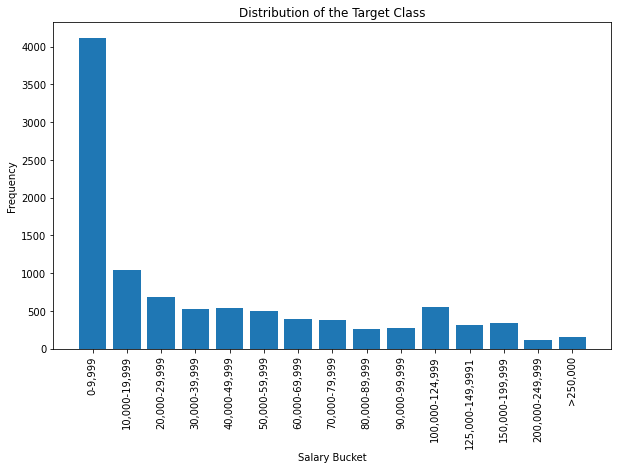

In [32]:
# creating a mapper that will map the output of the OLR algorithm to the interpretable buckets of salary
target_mapping = ({0:'0-9,999', 1:'10,000-19,999', 2:'20,000-29,999', 3:'30,000-39,999', 4:'40,000-49,999', 
5:'50,000-59,999', 6:'60,000-69,999', 7:'70,000-79,999', 8:'80,000-89,999', 9:'90,000-99,999', 10:'100,000-124,999', 11:'125,000-149,9991', 12:'150,000-199,999', 13:'200,000-249,999', 14:'>250,000'})

class_dist = cleaned_dataset['Q24_Encoded'].value_counts().sort_index()
class_dist.index = class_dist.index.map(target_mapping)
plt.figure(figsize=(10,6))
plt.title('Distribution of the Target Class')
plt.bar(class_dist.index, class_dist.values)
plt.xticks(rotation=90)
plt.xlabel('Salary Bucket')
plt.ylabel('Frequency')
plt.show()

The dataset is unbalanced.

### Scaling of the predictors
**Scaling of the predictors is not necessary because all the predictors are categorical feature which are either label encoded on dummy encoded.**

**Splitting the dataset into training and test set. The splitting is done before feature selection to avoid information leakage to the model.**

In [33]:
X_train, X_test, y_train, y_test = train_test_split(feature_dataset, target_dataset, test_size=0.3, random_state=0)

# Feature Selection Technique
Chi-Squared test is used for feature selection. The chi-square test checks whether two categorical variables are independent.If the feature is independent of the target, then the feature will likely not be useful in predicting the target. If they are not independent, then the feature will most likely have predictive power on the target.

In [34]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

selector = SelectKBest(chi2, k='all')
selector.fit_transform(X_train, y_train)
indices = selector.get_support(indices=True)

features_names = X_train.iloc[:,indices].columns
features_pvalue = selector.pvalues_
features_score = selector.scores_

In [35]:
feature_importance = pd.DataFrame({'features':features_names, 'p_values':features_pvalue, 'scores':features_score})
feature_importance.sort_values('p_values')

,features,p_values,scores
16,Q3_US,0.000000e+00,1875.665615
4,Q15,0.000000e+00,1565.594147
8,Q25,0.000000e+00,1559.367037
0,Q1,9.845000e-305,1466.026861
2,Q6,1.898233e-228,1111.402899
6,Q21,4.625429e-209,1021.108487
5,Q20,1.477307e-161,799.412386
7,Q22,1.607885e-103,527.162399
12,Q3_India,1.991789e-99,507.867797
35,Q23,3.595408e-71,374.090312


### Feature Importance

The lower the p-value for the features, the more significant the features are. Also, the higher the chi-square score for a feature, the more dependent it is on the target variable. Hence, it can be selected for model training.


### Visualizing feature importance

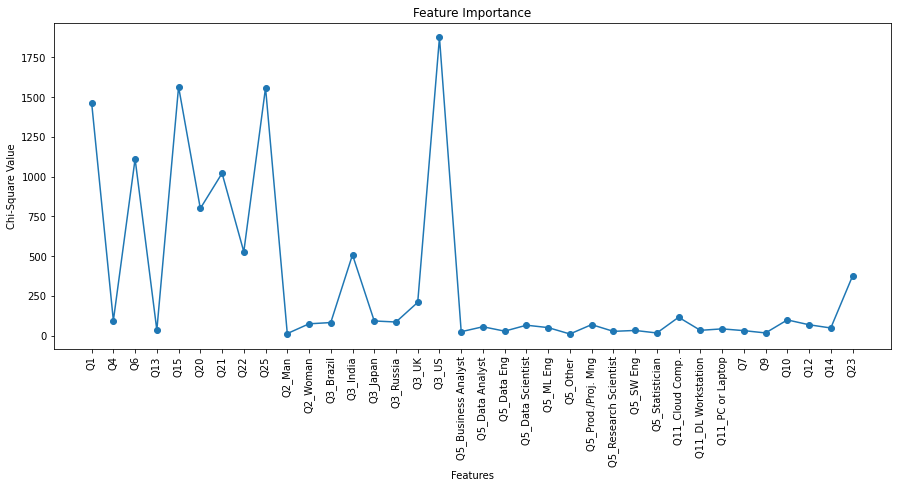

In [36]:
vis_feat_imprt = feature_importance[['features', 'scores']]
plt.figure(figsize=(15, 6))
plt.plot('features', 'scores', data=vis_feat_imprt, marker='o')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Chi-Square Value')
plt.title('Feature Importance')
plt.show()

The original attributes in the data that are most related to a survey respondent's yearly compensation are `Q1-Age, Q6-years of programming experience, Q15-years of experience with machine learning methods, Q3-Country (majorly US and India), Q20-employee size in the respondent's company, Q21-number of individual responsible for data science workloads at the respondent place of work, Q23-incorporation of machine learning into their business, Q25-money spent on machine learning and computing services, and Q23-activities of their role at work`.

### Selecting features
The predictors are selected by setting alpha<=`0.05` for their p-values. The features whose p-values are between `0` and `0.05` are dependent on the target variable(useful predictors) while those whose values are above `0.05` are independent of the target variable(useless predictors).

In [37]:
features_selected = feature_importance[feature_importance['p_values'] <= 0.05]['features'].values
features_selected

array(['Q1', 'Q4', 'Q6', 'Q13', 'Q15', 'Q20', 'Q21', 'Q22', 'Q25',
       'Q2_Woman', 'Q3_Brazil', 'Q3_India', 'Q3_Japan', 'Q3_Russia',
       'Q3_UK', 'Q3_US', 'Q5_Business Analyst', 'Q5_Data Analyst',
       'Q5_Data Eng', 'Q5_Data Scientist', 'Q5_ML Eng',
       'Q5_Prod./Proj. Mng', 'Q5_Research Scientist', 'Q5_SW Eng',
       'Q11_Cloud Comp.', 'Q11_DL Workstation', 'Q11_PC or Laptop', 'Q7',
       'Q10', 'Q12', 'Q14', 'Q23'], dtype=object)

### Selecting the best features for both `X_train` and `X_test` 

In [38]:
X_train = X_train[features_selected]
X_test = X_test[features_selected]

# QUESTION 3 AND 4- Model Implementation & Hyperparameter Tuning

Implementation and Tuning of the `Ordinal Logistic Regression (OLR)` algorithm on the training dataset using `10-fold cross-validation`.

### Identifying the parameters in the logistic regression model.
 * **C (Inverse Regularization Strength)**- controls the trade-off between allowing the model to increase it's complexity as much as it wants with trying to keep it simple. For example, if C is very high, the model will have enough power to increase it's complexity (overfit) by assigning big values to the weights for each parameter. If, in the other hand, we reduce the value of C,the model will tend to underfit, as the model will become too simple.
 * **Penalty**- (`l1`, `l2`)- A model penalized by `l1` is called Lasso Regression and model penalized by `l2` is called Ridge Regression. Ridge regression adds `squared magnitude` of coefficient as penalty term to the loss function while Lasso regression adds `absolute value` of the magnitude of coefficients.
 * **max_iter**- The maximum number of iterations taken for the solvers of the logistic regression to converge `liblinear`, `lbfgs`, `newton-cg` and so on.
 * **Other Hyperparameters**- `solver`, `multi_class` and so on.
 
### Hyperparameters to be tuned.
 * C (Inverse Regularization Strength) - We are tuning the `C` parameter because when a model is trained, it learns the tiniest detail present in the data; hence, the model performs very well on training data and poorly on unseen data. Setting the right value for `C` reduces the chance of overfitting or underfitting.
 * Penalty - the `l1` and `l2` penalties adjust the coefficient of each parameters. `l1` shrinks the coefficients of less important feature to remove or remove the parameters altogether. While `l2` also reduces the coefficient of parameters, it doesn't remove any feature.


 ### Suitable accuracy measure for tuning.
 Accuracy - The performance metrics selected is accuracy `Correct Predictions/Total Predictions`, since the interest is about the correct predictions (yearly compensation) the model can make, and not how wrongly it classifies other classes.
 
  

In [39]:
# columns for the output of the OLR algorithm for readability
output_col = (['0-9,999', '10,000-19,999', '20,000-29,999', '30,000-39,999', '40,000-49,999', 
'50,000-59,999', '60,000-69,999', '70,000-79,999', '80,000-89,999', '90,000-99,999', '100,000-124,999', '125,000-149,9991', '150,000-199,999', '200,000-249,999', '>250,000'])

# # initialising the logic regression and 10-fold
# model = LogisticRegression()
# kfold = KFold(n_splits=10)
# kfold.get_n_splits(X_train)

# # best model parameter
# best_model = model
# best_params = {}
# best_accuracy = 0
# best_std = 0

# # hyperparameter tuning - C(inverse of regularization strength) and penalty('l1' and 'l2') 
# for C in [0.001,0.01,0.05,0.1,0.5,1,2,3,4,5,10, 100]:
#     for penalty in ['l1', 'l2']:
        
#         # using 'liblinear' solver since it supports 'l1' and 'l2' penalty
#         model = LogisticRegression(C=C, penalty=penalty, solver='liblinear')
#         accuracy = np.zeros(10)
#         np_idx = 0

#         # the OLR algorithm
#         for train_idx, test_idx in kfold.split(X_train):
#             X_train_fold, X_test_fold = X_train.values[train_idx], X_train.values[test_idx]
#             y_train_fold, y_test_fold = y_train.values[train_idx], y_train.values[test_idx]
            
#             # computing the probability that each entry will belong to a group of class
#             list_df = list()
#             for idx, dfs in enumerate(sorted(y_train.unique())[:-1]):

#                 # regrouping the target variable class before fitting and prediction
#                 y_train_modified = np.apply_along_axis(lambda x: np.where(x <= dfs, 0, 1), 0, y_train_fold)
#                 model.fit(X_train_fold, y_train_modified)

#                 predict_dfs = model.predict_proba(X_test_fold)
#                 df_predict = pd.DataFrame(predict_dfs)
                
#                 list_df.append(df_predict)

#             # computing the probability for each row to belong to each of the bucket (should sum up to 1 per row)
#             main_df = pd.DataFrame()
#             for idx, iters in enumerate(list_df):
#                 if idx == 0:
#                     main_df = main_df.append(iters[[0]])
#                 else:
#                     prev_df = list_df[idx-1]
#                     main_df = main_df.join(pd.DataFrame(iters.iloc[:, 0]-prev_df.iloc[:, 0]), lsuffix='new')

#                 if idx == (len(list_df)-1):
#                     main_df = main_df.join(iters.iloc[:, 1], lsuffix='new')
#                     main_df.columns = output_col

#             # selecting the bucket salary with the highest probability for each row 
#             output_bucket = main_df.idxmax(axis=1)

#             # mapping the numerical output to their correspoding salary bucket
#             y_test_fold_bucket = pd.Series(y_test_fold).map(target_mapping)
            
#             # calculating the accuracy of the model
#             correct_prediction = sum(output_bucket == y_test_fold_bucket)
#             total_prediction = len(y_test_fold_bucket)
#             ACC = correct_prediction / total_prediction

#             accuracy[np_idx] = ACC*100
#             np_idx += 1
            
#         # condition for selecting best model
#         if np.mean(accuracy) > best_accuracy:
#             best_model = model
#             best_params = {'C':C, 'penalty':penalty}
#             best_accuracy = np.mean(accuracy)
#             best_std = np.std(accuracy)

# print (best_params)
# print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

# print ("\nThe optimal log model uses C={}, and a {} penalty, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['penalty'],round(best_accuracy,3),round(best_std,3)))

### Optimal Model
Best Score: `43.568%(2.501%)`

The optimal log model uses `C=1`, and a `l1` penalty, and has a cross validation score of `43.586%` with a standard deviation of `2.501%`

### Exploring the performance of the optimal model across 10 folds.

In [40]:
# initialising the logic regression and 10-fold
model = LogisticRegression(C=1, penalty='l1', solver='liblinear')
kfold = KFold(n_splits=10)
kfold.get_n_splits(X_train)

accuracy = np.zeros(10)
np_idx = 0

# the OLR algorithm
for train_idx, test_idx in kfold.split(X_train):
    X_train_fold, X_test_fold = X_train.values[train_idx], X_train.values[test_idx]
    y_train_fold, y_test_fold = y_train.values[train_idx], y_train.values[test_idx]
    
    # computing the probability that each entry will belong to a group of class
    list_df = list()
    for idx, dfs in enumerate(sorted(y_train.unique())[:-1]):

        # regrouping the target variable class before fitting and prediction
        y_train_modified = np.apply_along_axis(lambda x: np.where(x <= dfs, 0, 1), 0, y_train_fold)
        model.fit(X_train_fold, y_train_modified)

        predict_dfs = model.predict_proba(X_test_fold)
        df_predict = pd.DataFrame(predict_dfs)
        
        list_df.append(df_predict)

    # computing the probability for each row to belong to each of the bucket (should sum up to 1 per row)
    main_df = pd.DataFrame()
    for idx, iters in enumerate(list_df):
        if idx == 0:
            main_df = main_df.append(iters[[0]])
        else:
            prev_df = list_df[idx-1]
            main_df = main_df.join(pd.DataFrame(iters.iloc[:, 0]-prev_df.iloc[:, 0]), lsuffix='new')

        if idx == (len(list_df)-1):
            main_df = main_df.join(iters.iloc[:, 1], lsuffix='new')
            main_df.columns = output_col

    # selecting the bucket salary with the highest probability for each row 
    output_bucket = main_df.idxmax(axis=1)

    # mapping the numerical output to their correspoding salary bucket
    y_test_fold_bucket = pd.Series(y_test_fold).map(target_mapping)

    # calculating the accuracy of the model
    correct_prediction = sum(output_bucket == y_test_fold_bucket)
    total_prediction = len(y_test_fold_bucket)
    ACC = correct_prediction / total_prediction
    
    accuracy[np_idx] = ACC*100
    np_idx += 1

    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))   
print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))

Fold 1: Accuracy: 0.397%
Fold 2: Accuracy: 0.426%
Fold 3: Accuracy: 0.454%
Fold 4: Accuracy: 0.416%
Fold 5: Accuracy: 0.456%
Fold 6: Accuracy: 0.445%
Fold 7: Accuracy: 0.468%
Fold 8: Accuracy: 0.429%
Fold 9: Accuracy: 0.468%
Fold 10: Accuracy: 0.399%
Average Score: 43.586%(2.501%)


**The accuracy of the optimal model across the 10 folds ranges between `39.7%` to `46.8%` with an average accuracy of `43.586%` and standard deviation of `2.501%`.**

**The average accuracy of the optimal model across the 10 folds is almost between the the minium and maximum accuracy achieved by the model across the 10 folds(`(39.7)/(46.8)=43.25%`); this indicates low-bias. The standard deviation of the accuracies across the 10 folds is low `(2.501%)`; this shows that the optimal model does not vary a lot with different dataset, hence low-variance.**

**Checking the performance of the optimal model on the training set.**

In [41]:
# initializing the optimal model
model = LogisticRegression(C=1, penalty='l1', solver='liblinear')

# making prediction on the training set
list_df = list()
for idx, dfs in enumerate(sorted(y_train.unique())[:-1]):
    y_train_modified = y_train.apply(lambda x: 0 if x <= dfs else 1)
    model.fit(X_train, y_train_modified)

    predict_dfs = model.predict_proba(X_train)
    df_predict = pd.DataFrame(predict_dfs)
    
    list_df.append(df_predict)

main_df = pd.DataFrame()
for idx, iters in enumerate(list_df):
    if idx == 0:
        main_df = main_df.append(iters[[0]])
    else:
        prev_df = list_df[idx-1]
        main_df = main_df.join(pd.DataFrame(iters.iloc[:, 0]-prev_df.iloc[:, 0]), lsuffix='new')

    if idx == (len(list_df)-1):
        main_df = main_df.join(iters.iloc[:, 1], lsuffix='new')
        main_df.columns = output_col

output_bucket = main_df.idxmax(axis=1)
y_train_bucket = y_train.map(target_mapping)

correct_prediction = sum(output_bucket.values == y_train_bucket.values)
total_prediction = len(y_train_bucket)
ACC = correct_prediction / total_prediction

print('The accuracy of the optimal model on the training set is: {:.2%}'.format(ACC))

The accuracy of the optimal model on the training set is: 44.44%


In [42]:
# cross-checking the probability of each row if it sums up to 1
main_df.sum(axis=1).value_counts()

1.0    7117
dtype: int64

### Probability of belonging to each salary bucket for the training set.

In [43]:
main_df

,"0-9,999","10,000-19,999","20,000-29,999","30,000-39,999","40,000-49,999","50,000-59,999","60,000-69,999","70,000-79,999","80,000-89,999","90,000-99,999","100,000-124,999","125,000-149,9991","150,000-199,999","200,000-249,999",">250,000"
0,0.868586,0.086360,0.019625,0.007825,0.005568,0.004027,0.002504,0.001612,0.001041,0.000652,0.001450,0.000308,0.000062,-0.000046,0.000427
1,0.500537,0.140058,0.093617,0.060601,0.068145,0.050371,0.024028,0.022864,0.015423,0.007569,0.011087,0.003180,0.000178,0.001801,0.000541
2,0.412158,0.164653,0.098577,0.068318,0.067613,0.057165,0.038173,0.024892,0.018307,0.011043,0.022230,0.008181,0.005416,0.000061,0.003211
3,0.668303,0.110001,0.065392,0.042301,0.042709,0.025909,0.015254,0.011076,0.006329,0.003598,0.006190,0.001670,0.000286,0.000748,0.000234
4,0.090138,0.017457,0.055079,0.081454,0.137403,0.116355,0.145873,0.060855,0.064586,0.067275,0.057054,-0.006448,0.075830,0.019784,0.017306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7112,0.399597,0.146021,0.081341,0.087968,0.092677,0.066427,0.042049,0.030090,0.013378,0.009331,0.017567,0.007283,0.000318,0.000987,0.004967
7113,0.519707,0.155888,0.073688,0.091547,0.060650,0.029257,0.027906,0.014481,0.005785,0.000759,0.010946,0.004593,0.003310,-0.000992,0.002474
7114,0.068427,0.021401,0.016743,0.023938,0.045897,0.062802,0.035425,0.107235,0.029071,0.078397,0.279419,0.047061,0.146137,0.020790,0.017257
7115,0.308944,0.096870,0.099034,0.085536,0.119252,0.077596,0.058406,0.043259,0.032030,0.017015,0.038222,0.007483,0.008777,0.003025,0.004552


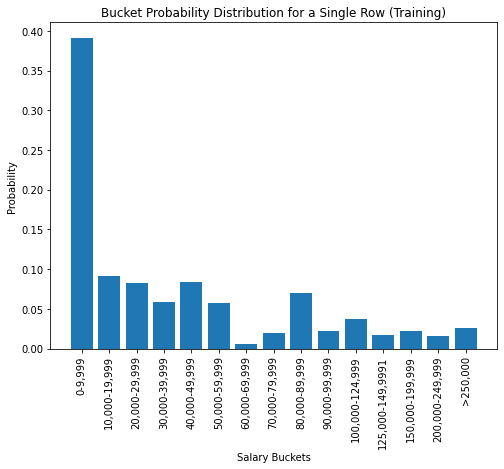

In [44]:
# plotting the probability distribution for a row
plt.figure(figsize=(8,6))
plt.bar(main_df.columns, main_df.iloc[10])
plt.xticks(rotation=90)
plt.title('Bucket Probability Distribution for a Single Row (Training)')
plt.ylabel('Probability')
plt.xlabel('Salary Buckets')
plt.show()

In [45]:
# structuring the data for plotting
train_plot_predict = output_bucket.value_counts()
train_values_predict=[]
for col in output_col:
    if col in train_plot_predict.index:
        train_values_predict.append(train_plot_predict[col])
    else:
        train_values_predict.append(0)

train_plot_true = y_train_bucket.value_counts()
train_values_true=[]
for col in output_col:
    if col in train_plot_true.index:
        train_values_true.append(train_plot_true[col])
    else:
        train_values_true.append(0)

# QUESTION 5 - Testing & Discussion

**Testing the optimal model on the test set.**

In [46]:
# initializing the optimal model
model = LogisticRegression(C=1,penalty='l1', solver='liblinear')

# making prediction on the test set
list_df = list()
for idx, dfs in enumerate(sorted(y_train.unique())[:-1]):
    y_train_modified = y_train.apply(lambda x: 0 if x <= dfs else 1)
    model.fit(X_train, y_train_modified)

    predict_dfs = model.predict_proba(X_test)
    df_predict = pd.DataFrame(predict_dfs)
    
    list_df.append(df_predict)

main_df = pd.DataFrame()
for idx, iters in enumerate(list_df):
    if idx == 0:
        main_df = main_df.append(iters[[0]])
    else:
        prev_df = list_df[idx-1]
        main_df = main_df.join(pd.DataFrame(iters.iloc[:, 0]-prev_df.iloc[:, 0]), lsuffix='new')

    if idx == (len(list_df)-1):
        main_df = main_df.join(iters.iloc[:, 1], lsuffix='new')
        main_df.columns = output_col

output_bucket = main_df.idxmax(axis=1)
y_test_bucket = y_test.map(target_mapping)

correct_prediction = sum(output_bucket.values == y_test_bucket.values)
total_prediction = len(y_test_bucket)

ACC = correct_prediction / total_prediction

print('The accuracy of the optimal model on the test set is: {:.2%}'.format(ACC))

The accuracy of the optimal model on the test set is: 41.92%


**The accuracy of the optimal model on the training set is: `44.44%` as compared to `41.92%` on the test set. The accuracy on the training set is just `2.52%` above the test set; this indicates a good model that is.**

**The model is not overfitting but it's clearly underfitting because the model has low accuracy which indicates that it can't properly capture the relationship between the explanatory data and the reponse data. The poor performance is due to the imbalaced dataset.**

**The performance of the model can be improved by adding new domain-specific features and getting more samples of other classes to balance the dataset.**

In [47]:
main_df

,"0-9,999","10,000-19,999","20,000-29,999","30,000-39,999","40,000-49,999","50,000-59,999","60,000-69,999","70,000-79,999","80,000-89,999","90,000-99,999","100,000-124,999","125,000-149,9991","150,000-199,999","200,000-249,999",">250,000"
0,0.454772,0.242687,0.100326,0.037834,0.034884,0.034687,0.023319,0.018439,0.002922,0.005991,0.018950,0.008693,0.009963,-0.003220,0.009755
1,0.744569,0.083342,0.050551,0.031319,0.028587,0.022232,0.014313,0.006199,0.004087,0.002537,0.006233,0.002662,0.001925,-0.000519,0.001961
2,0.056272,0.050669,0.044428,0.046083,0.078993,0.079765,0.079872,0.125853,0.077670,0.071552,0.127574,0.065617,0.056574,0.013489,0.025589
3,0.067505,0.058431,0.054447,0.042808,0.091808,0.050265,0.065820,0.098837,0.065511,0.119845,0.134191,0.081073,0.042307,0.013019,0.014133
4,0.879556,0.042561,0.016390,0.018194,0.008945,0.004767,0.007875,0.004225,0.005247,0.000894,0.004379,0.002872,0.002321,-0.000959,0.002732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3046,0.326059,0.148010,0.104925,0.079989,0.065170,0.067307,0.051075,0.042499,0.043712,0.022428,0.029920,0.010983,0.005357,0.001319,0.001247
3047,0.740794,0.057440,0.050342,0.041930,0.016687,0.021512,0.017041,0.011325,0.009082,0.004532,0.010921,0.008788,0.006411,-0.002519,0.005715
3048,0.884895,0.068248,0.020764,0.006774,0.004183,0.004320,0.002788,0.001869,0.000620,-0.000814,0.001960,0.000031,0.001281,0.000884,0.002199
3049,0.124126,0.017156,0.020294,0.015836,0.030245,0.008654,0.030186,0.075457,0.069737,0.105975,0.160610,0.167463,0.105294,0.040349,0.028620


### Plotting the distribution of true target variable values and their predictions on training and test set.

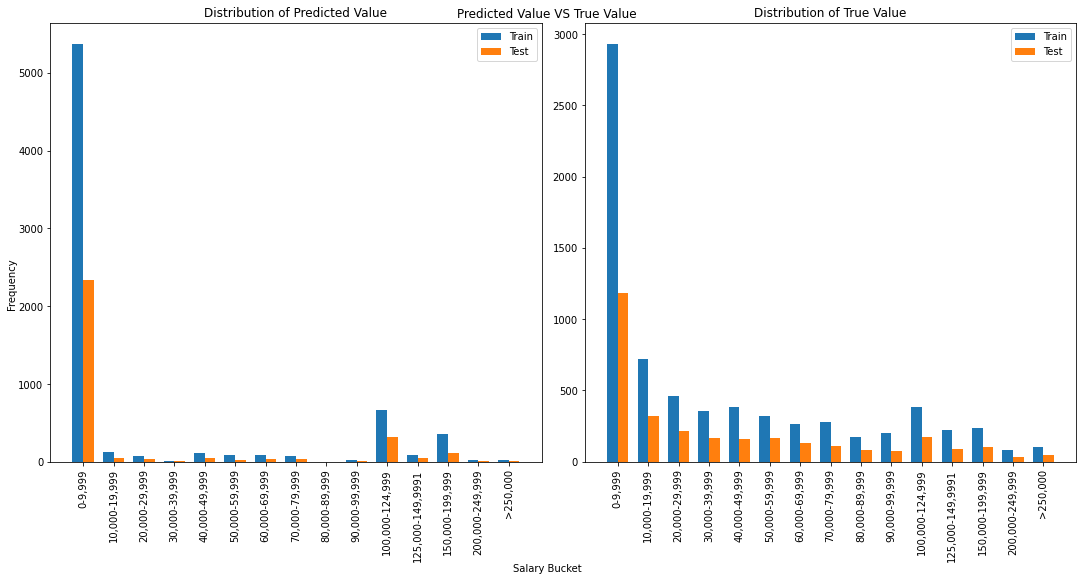

In [48]:
# structuring the data for plotting
test_plot_predict = output_bucket.value_counts()
test_values_predict=[]
for col in output_col:
    if col in test_plot_predict.index:
        test_values_predict.append(test_plot_predict[col])
    else:
        test_values_predict.append(0)

test_plot_true = y_test_bucket.value_counts()
test_values_true=[]
for col in output_col:
    if col in test_plot_true.index:
        test_values_true.append(test_plot_true[col])
    else:
        test_values_predict.append(0)

x = np.arange(len(output_col))  # the label locations
width = 0.35  # the width of the bars

# plotting the distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
fig.suptitle('Predicted Value VS True Value')

fig.text(0.5, 0, 'Salary Bucket', ha='center')
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical')

ax1.bar(x - width/2, train_values_predict, label='Train', width=width)
ax1.bar(x + width/2, test_values_predict, label='Test', width=width)
ax1.tick_params(axis='x', labelrotation = 90)
ax1.set_title('Distribution of Predicted Value')
ax1.set_xticks(x)
ax1.set_xticklabels(output_col)

ax2.bar(x - width/2, train_values_true, label='Train', width=width)
ax2.bar(x + width/2, test_values_true, label='Test', width=width)
ax2.tick_params(axis='x', labelrotation = 90)
ax2.set_title('Distribution of True Value')
ax2.set_xticks(x)
ax2.set_xticklabels(output_col)

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

**The dataset set used in the creation of the ordinal logistic regression model is unbalanced and this has a huge effect on the performance of the model. The distribution plot for the prediction on the training and test set are similar which shows that the model generalizes on the features available to it; providing more domain-specifc features to it will surely improve its performance.**